<a target="_blank" href="https://colab.research.google.com/github/pywavelet/pywavelet/blob/main/docs/examples/accuracy.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Backend Accuracy checks


In [ ]:
! pip install pywavelet -q

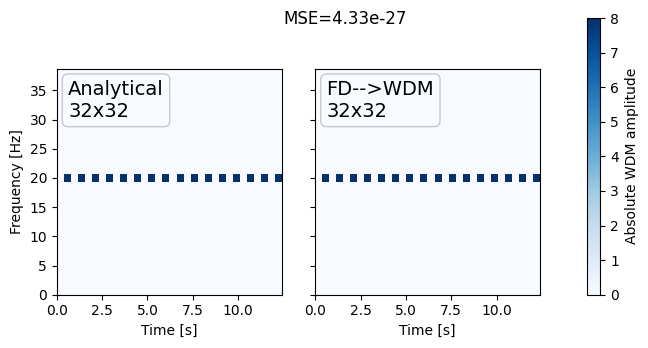

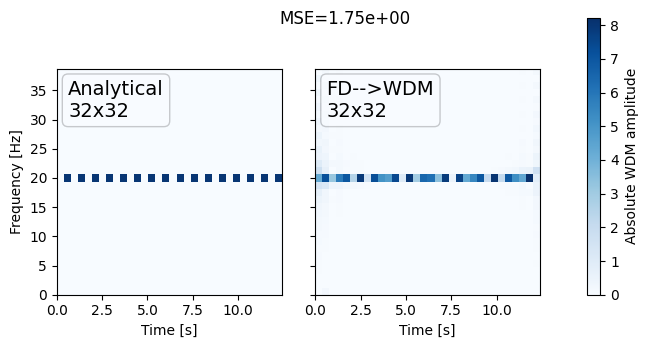

In [84]:
from pywavelet.types import Wavelet, FrequencySeries, TimeSeries
from pywavelet.types.wavelet_bins import compute_bins
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm


@dataclass
class Params:
    f0: float = 20
    dt: float = 0.0125
    A: float = 1
    Nt: int = 32
    Nf: int = 32

    @property
    def list(self):
        return [self.f0, self.dt, self.A, self.Nt, self.Nf]

    def __repr__(self):
        return f"f0={self.f0}, A={self.A}"


def monochromatic_wnm(
    f0: float,
    dt: float,
    A: float,
    Nt: int,
    Nf: int,
) -> Wavelet:
    T = Nt * Nf * dt
    N = Nt * Nf
    t_bins, f_bins = compute_bins(Nf, Nt, T)
    wnm = np.zeros((Nt, Nf))
    m0 = int(f0 * N * dt)
    f0_bin_idx = int(2 * m0 / Nt)
    odd_t_indices = np.arange(Nt) % 2 != 0
    wnm[odd_t_indices, f0_bin_idx] = A * np.sqrt(2 * Nf)
    return Wavelet(wnm.T, t_bins, f_bins)


def monochromatic_timeseries(
    f0: float,
    dt: float,
    A: float,
    Nt: int,
    Nf: int,
) -> TimeSeries:
    ND = Nt * Nf
    t = np.arange(0, ND) * dt
    y = A * np.sin(2 * np.pi * f0 * t)
    return TimeSeries(data=y, time=t)


default_params = Params()


def plot_comparison(params):

    true_wdm = monochromatic_wnm(*params.list)
    true_tdm = monochromatic_timeseries(*params.list)
    fdm = true_tdm.to_frequencyseries()
    wdm = fdm.to_wavelet(Nt=params.Nt, Nf=params.Nf)
    mse = np.mean((wdm.data - true_wdm.data) ** 2)

    fig, ax = plt.subplots(1, 2, figsize=(7, 3.5), sharex=True, sharey=True)
    norm = Normalize(vmin=0, vmax=wdm.data.max())
    kwargs = dict(absolute=True, norm=norm, cmap="Blues", show_colorbar=False)
    true_wdm.plot(ax=ax[0], **kwargs, label="Analytical")
    wdm.plot(ax=ax[1], **kwargs, label="FD-->WDM")
    ax[1].set_ylabel("")
    # set common colorbar using norm
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    fig.colorbar(
        sm, ax=ax, orientation="vertical", label="Absolute WDM amplitude"
    )
    fig.suptitle(f"MSE={mse:.2e}")
    # tight layout whle accommodating suptitle + colorbar
    fig.tight_layout(rect=[0, 0, 0.8, 0.95])
    plt.show()


plot_comparison(Params(f0=20, A=1))
plot_comparison(Params(f0=20.1, A=1))

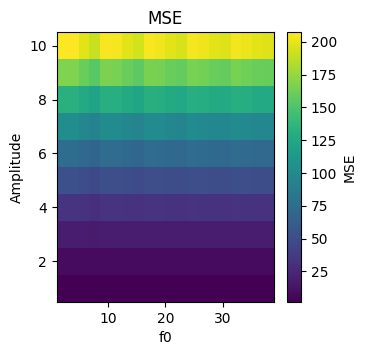

In [102]:
Namp, Nfreq = 10, 20
amplitudes = np.linspace(1, 10, Namp)
f0s = np.linspace(2, 38, Nfreq)

errors = np.zeros((Namp, Nfreq))
for i, A in enumerate(amplitudes):
    for j, f0 in enumerate(f0s):
        p = Params(f0=f0, A=A)
        true = monochromatic_wnm(*p.list)

        wdm = (
            monochromatic_timeseries(*p.list)
            .to_frequencyseries()
            .to_wavelet(Nt=p.Nt, Nf=p.Nf)
        )
        errors[i, j] = np.mean((wdm.data - true.data) ** 2)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
# plot grid of errors as a function of amplitude and frequency
c = ax.pcolormesh(f0s, amplitudes, errors)

ax.set_xlabel("f0")
ax.set_ylabel("Amplitude")
ax.set_title("MSE")
fig.colorbar(c, ax=ax, label="MSE")

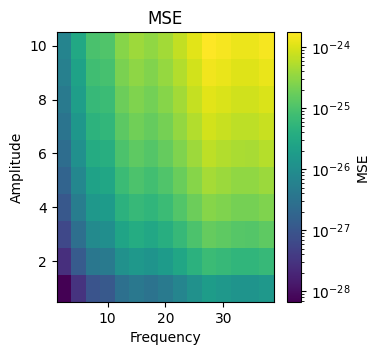

In [100]:
Namp, Nfreq = 10, 20
amplitudes = np.linspace(1, 10, Namp)
default_wdm = monochromatic_wnm(*default_params.list)
# arrange f0s such that the bin is  an integer multiple of Delta_F
f0s = default_wdm.freq[2::2]
# get midpoints of f0s

Nfreq = len(f0s)


errors = np.zeros((Namp, Nfreq))
for i, A in enumerate(amplitudes):
    for j, f0 in enumerate(f0s):
        p = Params(f0=f0, A=A)
        true = monochromatic_wnm(*p.list)

        wdm = (
            monochromatic_timeseries(*p.list)
            .to_frequencyseries()
            .to_wavelet(Nt=p.Nt, Nf=p.Nf)
        )
        errors[i, j] = np.mean((wdm.data - true.data) ** 2)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
# plot grid of errors as a function of amplitude and frequency
c = ax.pcolormesh(f0s, amplitudes, errors, norm=LogNorm())

ax.set_xlabel("f0")
ax.set_ylabel("Amplitude")
ax.set_title("MSE")
fig.colorbar(c, ax=ax, label="MSE")

In [101]:
f0s

array([ 2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. , 27.5,
       30. , 32.5, 35. , 37.5])

In [103]:
default_wdm.freq

array([ 0.  ,  1.25,  2.5 ,  3.75,  5.  ,  6.25,  7.5 ,  8.75, 10.  ,
       11.25, 12.5 , 13.75, 15.  , 16.25, 17.5 , 18.75, 20.  , 21.25,
       22.5 , 23.75, 25.  , 26.25, 27.5 , 28.75, 30.  , 31.25, 32.5 ,
       33.75, 35.  , 36.25, 37.5 , 38.75])